Learning Transformer

这个主要做baseline，也就是给一对时间序列的图片，然后让模型自己生成目标的恢复之后的结果。


这个既不用时间序列，也不用参考照片，只用目标序列前后的图片


然后云用mask做掩码来掩盖掉训练时的损失。

这个可以做baseline，因为他非常简单，并且比较容易实现。

In [1]:
# --------------------------------------------------------------------
# Importing required libraries
# --------------------------------------------------------------------
import random
import numpy as np
import pandas as pd
import PIL.Image as Image
from glob import glob
from mymodels import VisionTransformer, ReconNet
from mymodels.unet import Unet
from mymodels.discriminatorv2 import Discriminator
import matplotlib.pyplot as plt
from myutils import imshow
from datetime import datetime


# importing pytorch functions
import torch
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tvtransforms
from torch.nn import SmoothL1Loss, BCELoss

# importing utils required in th code
from utils import subsample
from utils import transforms
from utils.evaluate import ssim, psnr, nmse
from utils.losses import SSIMLoss, SSIMLoss_V1, MultiScaleLoss
from osgeo import gdal
import torch.nn.functional as F

# Device
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cuda'
# np.random.seed(42)
# random.seed(42)

print("******* STARTED AT ************", datetime.now())

/home/snt/miniconda3/envs/causal_vit_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/snt/miniconda3/envs/causal_vit_env/lib/python3.10/site-packages/timm/models/helpers.py:7: FutureWarning: Importing from timm.models.helpers is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/home/snt/miniconda3/envs/causal_vit_env/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


******* STARTED AT ************ 2025-01-08 22:11:37.606014


In [2]:
from typing import Any, Dict, Optional, Tuple, Union
from scipy.ndimage import gaussian_filter


def RealisticCloudMaskFunc(
    input: torch.tensor,
    seed: Optional[Union[int, Tuple[int, ...]]] = None,
    clouds_attributes: Optional[Dict[str, Any]] = None,
):

    clouds_attributes = clouds_attributes or {}
    scale = clouds_attributes.get(
        "scale", 2.0
    )  # Default to 1.0 if 'scale' is not provided
    threshold = clouds_attributes.get("threshold", 0.5)  # Default to 0.5
    blur = clouds_attributes.get("blur", 0.0)  # Default to 0.0
    cloud_size = clouds_attributes.get("cloud_size", 0.3)  # Default to 0.3
    cloud_count = clouds_attributes.get("cloud_count", 5)  # Default to 10

    if len(input.shape) != 3:
        raise ValueError("Shape should have 4 dimensions: [channels, height, width]")

    if seed is not None:
        np.random.seed(seed)

    channels, height, width = input.shape
    # Generate the base mask for a single spatial shape (height, width)
    mask = np.zeros((height, width), dtype=np.float32)

    for _ in range(cloud_count):
        center_x = np.random.randint(0, width)
        center_y = np.random.randint(0, height)

        cloud_width = int(width * cloud_size)
        cloud_height = int(height * cloud_size)

        noise = np.random.rand(cloud_height, cloud_width)
        smooth_noise = gaussian_filter(noise, sigma=scale)
        cloud = smooth_noise > threshold

        x_start = max(center_x - cloud_width // 2, 0)
        y_start = max(center_y - cloud_height // 2, 0)
        x_end = min(center_x + cloud_width // 2, width)
        y_end = min(center_y + cloud_height // 2, height)

        mask[y_start:y_end, x_start:x_end] = np.maximum(
            mask[y_start:y_end, x_start:x_end],
            cloud[: y_end - y_start, : x_end - x_start],
        )

    if blur > 0:
        mask = gaussian_filter(mask, sigma=blur) > 0.5

    # Expand the mask to match the batch and channel dimensions
    mask = np.tile(mask, (channels, 1, 1))

    # Invert the mask (0s become 1s and 1s become 0s)
    mask = 1 - mask
    # Convert mask to tensor
    mask_tensor = torch.tensor(mask, dtype=torch.float32)

    # Apply the mask to the input image (masking the input)
    masked_input = input * mask_tensor

    return masked_input, mask_tensor

In [7]:
# --------------------------------------------------------------------
# Loading dataset
# --------------------------------------------------------------------
num_channel = 11


def transform_tensor_image(tensor_image):
    _, h, w = tensor_image.shape

    # 调整大小 (将输入调整为 64 * 3 的较大尺寸)
    target_size = 64 * 3
    tensor_image = F.interpolate(
        tensor_image.unsqueeze(0),
        size=(target_size, target_size),
        mode="bilinear",
        align_corners=False,
    ).squeeze(0)

    # 随机裁剪到 60 * 3 大小
    crop_size = 60 * 3
    start_x = torch.randint(0, target_size - crop_size + 1, (1,)).item()
    start_y = torch.randint(0, target_size - crop_size + 1, (1,)).item()
    tensor_image = tensor_image[
        :, start_y : start_y + crop_size, start_x : start_x + crop_size
    ]

    # 随机垂直翻转
    if torch.rand(1).item() < 0.5:
        tensor_image = torch.flip(tensor_image, dims=[1])  # 垂直翻转 (沿高度方向)

    # 随机水平翻转
    if torch.rand(1).item() < 0.5:
        tensor_image = torch.flip(tensor_image, dims=[2])  # 水平翻转 (沿宽度方向)

    return tensor_image


class ImagenetDataset(Dataset):
    def __init__(self, isval=False):

        if isval:
            ## combine paths of each imagenet validation image into a single list
            self.files = []
            pattern = "*.tif"
            for dir, _, _ in os.walk(
                "/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/output_all_times/val"
            ):
                self.files.extend(glob(os.path.join(dir, pattern)))
        else:
            ## combine paths of each imagenet training image into a single list
            self.files = []  # get path of each imagenet images
            pattern = "*.tif"
            for dir, _, _ in os.walk(
                "/home/snt/projects_lujun/Image-Reconstruction-by-Vision-Transformer/output_all_times/train"
            ):
                self.files.extend(glob(os.path.join(dir, pattern)))

        ##################### Change image size ########################
        ############## for best model, use tvtransforms.Resize(64*3,), tvtransforms.RandomCrop(60*3),
        # self.transform = tvtransforms.Compose(
        #     [
        #         tvtransforms.Resize(
        #             64 * 3,
        #         ),  # original 320
        #         tvtransforms.RandomCrop(60 * 3),  # original 272
        #         tvtransforms.Grayscale(1),
        #         tvtransforms.RandomVerticalFlip(p=0.5),
        #         tvtransforms.RandomHorizontalFlip(p=0.5),
        #         tvtransforms.ToTensor(),
        #     ]
        # )

        self.transform = transform_tensor_image
        ################################################################

        self.factors = [2, 3, 4, 5, 6, 7, 8, 9, 10]

    def read_tiff(self, file_path):
        dataset = gdal.Open(file_path)
        if not dataset:
            raise FileNotFoundError(f"Unable to open the file: {file_path}")
        band_count = dataset.RasterCount
        bands_data = []
        for i in range(1, band_count + 1):
            band = dataset.GetRasterBand(i)  # 获取波段对象
            band_name = band.GetDescription()  # 获取波段的描述信息
            band_data = band.ReadAsArray()  # 读取波段数据为 NumPy 数组
            bands_data.append(band_data)

        image = np.stack(bands_data, axis=0)
        return image

    def get_mask_func(
        self,
        samp_style,
        factor,
    ):
        center_fractions = 0.08 * 4 / factor
        if samp_style == "random":
            mask_func = subsample.RandomMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        elif samp_style == "equidist":
            mask_func = subsample.EquispacedMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        return mask_func

    def add_gaussian_noise(self, x):
        ch, row, col = x.shape
        mean = 0
        var = 0.05
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (ch, row, col))
        gauss = gauss.reshape(ch, row, col)
        noisy = x + gauss
        return noisy.float()

    def __len__(
        self,
    ):

        return len(self.files)

    def __getitem__(self, idx):
        # image = Image.open(self.files[idx]).convert("RGB")
        # print(idx)
        image = torch.from_numpy(self.read_tiff(self.files[idx]))[
            0:num_channel, :, :
        ]  # 先取前11个
        y = self.transform(image)
        cloud_mask = np.isnan(y).any(axis=0)
        y[:, cloud_mask.bool()] = 0
        masked_kspace = y.clone()
        masked_kspace[:, cloud_mask.bool()] = 0

        if random.uniform(0, 1) < 0.5:
            y = torch.rot90(y, 1, [-2, -1])

        if random.uniform(0, 1) < 0.5:
            samp_style = "random"
        else:
            samp_style = "equidist"

        # factor = random.choice(self.factors)
        mask_func = self.get_mask_func(
            samp_style, factor=2.5
        )  # 我们可以随机选择需要的factor

        # masked_kspace, _ = transforms.apply_mask(y, mask_func)

        masked_kspace, masked_input = RealisticCloudMaskFunc(masked_kspace)
        # masked_kspace = self.add_gaussian_noise(y)

        ## (C, H, W)
        return (
            masked_kspace,
            y,
            cloud_mask,
        )  # return iamge with masks, traget reference iamge and mask with cloud


dataset = ImagenetDataset()
val_dataset = ImagenetDataset(isval=True)
train_dataset = ImagenetDataset(isval=False)
# ntrain = len(dataset)
# ntrain = 200
# train_dataset, _ = torch.utils.data.random_split(
#     dataset,
#     [ntrain, len(dataset) - ntrain],
#     generator=torch.Generator().manual_seed(42),
# )
############## for best model, use batch_size = 45 (not sure)
batch_size = 10
epoch = 2
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
trainloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=2,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)
valloader = DataLoader(
    val_dataset,
    batch_size=10,
    shuffle=True,
    # num_workers=1,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)

Test the mask and future application

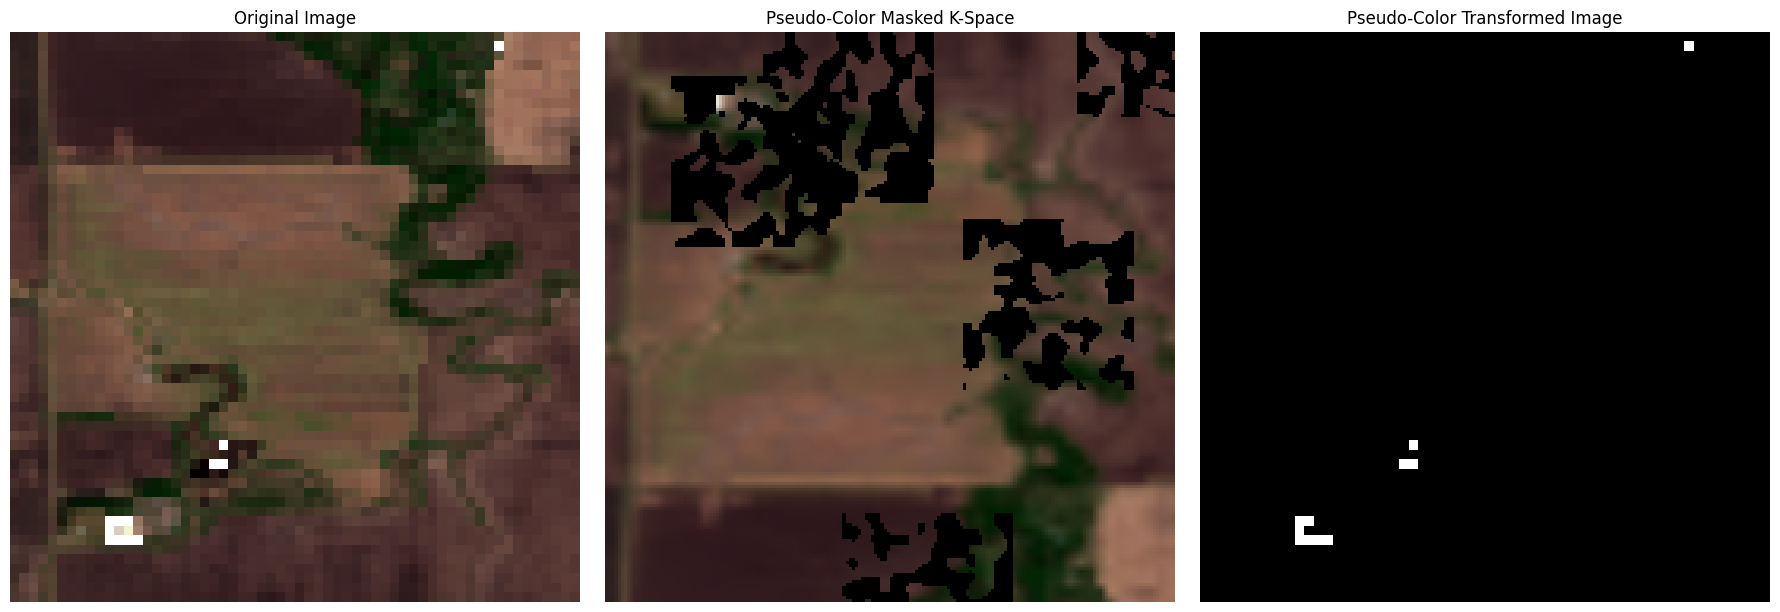

In [8]:
def read_tiff(file_path):
    dataset = gdal.Open(file_path)
    if not dataset:
        raise FileNotFoundError(f"Unable to open the file: {file_path}")
    band_count = dataset.RasterCount
    bands_data = []
    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)  # 获取波段对象
        band_name = band.GetDescription()  # 获取波段的描述信息
        band_data = band.ReadAsArray()  # 读取波段数据为 NumPy 数组
        bands_data.append(band_data)

    image = np.stack(bands_data, axis=0)
    return image


def create_pseudo_color_image_with_nan_handling(multi_channel_array, channel_list):
    """
    将多通道 NumPy 数组根据选定通道生成伪彩色三通道图像，并处理 NaN 值。
    如果某个像素有 NaN 值，则该像素设置为黑色。

    参数:
        multi_channel_array (numpy.ndarray): 多通道图像，形状为 (H, W, C)，C 为通道数。
        channel_list (list): 包含三个整数的列表，分别表示要映射到 R, G, B 的通道索引。

    返回:
        numpy.ndarray: 伪彩色三通道图像，形状为 (H, W, 3)。
            值范围为 [0, 1]，所有 NaN 位置被设置为黑色。
    """
    # 检查输入数组的有效性
    if len(multi_channel_array.shape) != 3:
        raise ValueError("输入数组必须是三维的，形状应为 (H, W, C)")

    if len(channel_list) != 3:
        raise ValueError("通道列表必须包含 3 个索引，表示 R, G, B 映射")

    c, h, w = multi_channel_array.shape
    if max(channel_list) >= c or min(channel_list) < 0:
        raise ValueError(f"通道索引超出范围，输入数组具有 {c} 个通道")

    # 初始化伪彩色图像
    pseudo_color_image = np.transpose(multi_channel_array, (1, 2, 0))[
        :, :, channel_list
    ]

    # 添加云指示图片
    nan_mask = np.isnan(pseudo_color_image).any(axis=-1)  # 掩码，标记 NaN 的位置
    background_cloud_image = np.full((h, w, 3), 0, dtype=np.uint8)
    background_cloud_image[nan_mask] = [255, 255, 255]

    # pseudo_color_image[nan_mask] = [0, 0, 0]  # 将 NaN 对应像素设置为红色

    # # 归一化到 [0, 1] 范围，避免颜色失真
    # valid_mask = ~nan_mask  # 非 NaN 的有效像素
    # pseudo_color_image[valid_mask] -= pseudo_color_image[valid_mask].min()
    # pseudo_color_image[valid_mask] /= (
    #     pseudo_color_image[valid_mask].max() + 1e-6
    # )  # 防止除以 0

    return pseudo_color_image, background_cloud_image


import matplotlib.pyplot as plt


def test_image_transformation(dataset, idx):
    # 1. 加载原始图像
    original_image = read_tiff(dataset.files[idx])
    original_image_np = np.array(original_image)  # 转为numpy数组方便显示

    # 2. 使用 __getitem__ 方法获取经过数据增强后的图像
    masked_kspace, transformed_image, cloud_mask = dataset[idx]

    pseudo_color_image_original, background_cloud_image_1 = (
        create_pseudo_color_image_with_nan_handling(original_image, [3, 2, 1])
    )

    # 转换 PyTorch tensor 为 NumPy 数组进行显示和可视化
    pseudo_color_image_transformed, background_cloud_image_2 = (
        create_pseudo_color_image_with_nan_handling(transformed_image, [3, 2, 1])
    )
    pseudo_color_image_masked_kspace, background_cloud_image_3 = (
        create_pseudo_color_image_with_nan_handling(masked_kspace, [3, 2, 1])
    )

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    axes[0].imshow(
        pseudo_color_image_original, cmap="gray"
    )  # 原始图像（假设是单波段灰度图）
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(pseudo_color_image_masked_kspace)  # 伪彩色的 masked_kspace
    axes[1].set_title("Pseudo-Color Masked K-Space")
    axes[1].axis("off")

    axes[2].imshow(background_cloud_image_1)  # 伪彩色的 transformed_image
    axes[2].set_title("Pseudo-Color Transformed Image")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


idx = 7460  # 测试某个索引的图像
test_image_transformation(dataset, idx)

In [9]:
# --------------------------------------------------------------------
# Initialising Models
# --------------------------------------------------------------------
# Vision Transformer
############## for best model, use avrg_img_size = 180
# from pytorch_msssim import ms_ssim

avrg_img_size = 180
patch_size = 5
depth = 6
num_heads = 8
embed_dim = 64
in_chans = 11
epoch = 100

net = VisionTransformer(
    avrg_img_size=avrg_img_size,
    patch_size=patch_size,
    in_chans=in_chans,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    is_LSA=False,  # ---------------Parameter for adding LSA component
    is_SPT=False,  # ---------------Parameter for adding SPT component
    rotary_position_emb=False,  # ---------------Parameter for adding ROPE component
    use_pos_embed=True,
)

# --------------- network for testing Unet architecture
# Unet - Uncomment for running the U-net Code
# net = Unet(
#     in_chans=1,
#     out_chans=1,
#     chans=64,
#     num_pool_layers=4,
#     )

# --------------------------------------------------------------------
# Creating a reconstruction network
# --------------------------------------------------------------------
model = ReconNet(net).to(device)

# Set biases to zero
for name, param in model.named_parameters():
    if name.endswith(".bias"):
        torch.nn.init.constant_(param, 0)
        param.requires_grad = False

print("#Params:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)


# --------------------------------------------------------------------
# Function to Save model
# --------------------------------------------------------------------
def save_model(path, model, train_hist, optimizer, scheduler=None):
    net = model.net
    if scheduler:
        checkpoint = {
            "model": ReconNet(net),
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
        }
    else:
        checkpoint = {
            "model": ReconNet(net),
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }

    torch.save(train_hist, path + "train_hist.pt")
    torch.save(checkpoint, path + "checkpoint.pth")


"""Choose optimizer"""

criterion = SSIMLoss_V1().to(device)
criterion = MultiScaleLoss(scales=[1, 0.5, 0.25], weight_mse=1.0, weight_sam=1.0).to(
    device
)
# criterion = MultiScaleLoss().to(device)
# criterion = ms_ssim().to(device)
# criterion = piq.ssim().to(device)
optimizerG = optim.Adam(model.parameters(), lr=0.0)
train_hist = []
path = "./"  # Path for saving model checkpoint and loss history
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizerG,
    max_lr=1e-4,
    total_steps=epoch,
    pct_start=0.1,
    anneal_strategy="linear",
    cycle_momentum=False,
    base_momentum=0.0,
    max_momentum=0.0,
    div_factor=0.1 * epoch,
    final_div_factor=9,
)

# --------------------------------------------------------------------
# Start to train the model
# --------------------------------------------------------------------

# ----------- discriminator parameters to test Adverserial loss addition to the network
run_discriminator = False


def check_nan_in_tensors(*tensors):
    for idx, tensor in enumerate(tensors):
        if torch.isnan(tensor).any():
            print(f"Tensor {idx} contains NaN values.")
            return True
    print("No NaN values found in the provided tensors.")
    return False

#Params: 17860096
ReconNet(
  (net): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(11, 512, kernel_size=(5, 5), stride=(5, 5))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-5): 6 x Block(
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): MHSA(
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=512, out_features=1056, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=352, out_features=512, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (drop_path): Identity()
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=512, out_features=2048, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=2048, out_features=512, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      

Start to train the model

In [10]:
# --------------------------------------------------------------------
# Start to train the model
# --------------------------------------------------------------------

# ----------- discriminator parameters to test Adverserial loss addition to the network

run_discriminator = False
for epoch in range(0, epoch):  # loop over the dataset multiple times
    model.train()
    train_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, targets, cloud_mask = data

        optimizerG.zero_grad()
        outputs = model(inputs.to(device))
        # Apply cloud_mask to outputs and targets
        masked_outputs = outputs * (1 - cloud_mask.to(device).unsqueeze(1))
        masked_targets = targets.to(device) * (1 - cloud_mask.to(device).unsqueeze(1))
        # Normalize the masked regions to avoid scale bias
        valid_pixels = cloud_mask.sum()
        if valid_pixels > 0:
            loss = (
                criterion(
                    masked_outputs.to(device),
                    masked_targets.to(device),
                )
                # / valid_pixels
            )
        else:
            loss = torch.tensor(0.0, device=device, requires_grad=True)
        # loss = criterion(
        #     outputs, targets.to(device), torch.tensor([1.0], device=device)
        # )
        # loss = criterion(outputs, targets.to(device))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=1, norm_type=1, error_if_nonfinite=True
        )
        optimizerG.step()

        train_loss += loss.item()

    scheduler.step()
    train_hist.append(train_loss / len(trainloader))
    save_model(path, model, train_hist, optimizerG, scheduler=scheduler)
    print("Epoch {}, Train loss.: {:0.4e}".format(epoch + 1, train_hist[-1]))

Epoch 1, Train loss.: 1.9420e+00
Epoch 2, Train loss.: 1.8285e+00


KeyboardInterrupt: 

*********** Testing ************ 2025-01-08 22:25:19.461500


FileNotFoundError: [Errno 2] No such file or directory: '/home/snt/projects_lujun/vitCausalSeries/output/imagenet_after_spt.png'

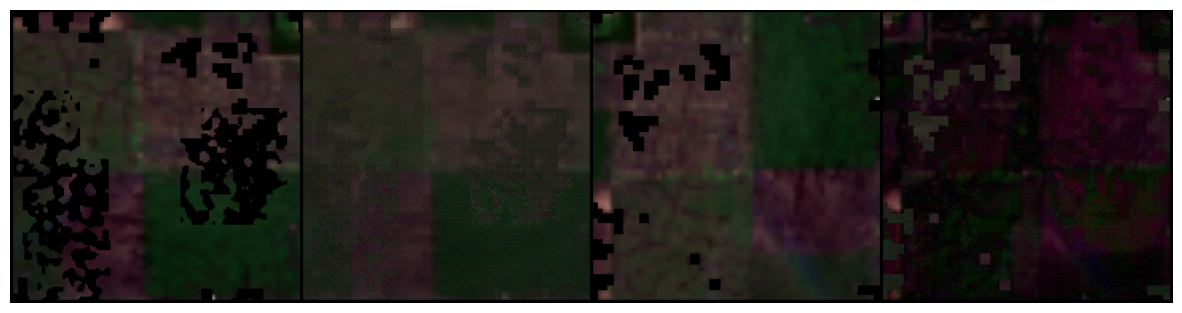

In [11]:
# --------------------------------------------------------------------
# Test the model trained
print("*********** Testing ************", datetime.now())
# --------------------------------------------------------------------

"""Example reconstructions"""
valloader = DataLoader(
    val_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    generator=torch.Generator().manual_seed(1),
)
dataiter = iter(valloader)
model.eval()
maxval = torch.tensor([1.0], device="cpu")

ssim_clean = []
ssim_noise = []
psnr_clean = []
psnr_noise = []
nmse_clean = []
nmse_noise = []

random_indices = random.sample(range(25, 30), 3)

with torch.no_grad():
    for i, (inputs, targets, cloud_mask) in enumerate(valloader):
        if i in random_indices:
            inputs, targets, cloud_mask = next(dataiter)
            outputs = model(inputs.to(device)).cpu()
            inputs_ = inputs
            # img_input = inputs_[0].numpy()
            img_input, _ = create_pseudo_color_image_with_nan_handling(
                inputs_[0], [3, 2, 1]
            )
            # img_noise = outputs[0].numpy()
            img_noise, _ = create_pseudo_color_image_with_nan_handling(
                outputs[0], [3, 2, 1]
            )
            # img = targets[0].numpy()
            img, _ = create_pseudo_color_image_with_nan_handling(targets[0], [3, 2, 1])
            plt.figure(figsize=(15, 7))
            imshow(
                make_grid(
                    [
                        img_input.permute(2, 0, 1),
                        img_noise.permute(2, 0, 1),
                        img.permute(2, 0, 1),
                        (img.permute(2, 0, 1) - img_noise.permute(2, 0, 1)).abs(),
                    ],
                    normalize=True,
                    value_range=(0, maxval[0]),
                )
            )
            plt.axis("off")
            plt.savefig("output/imagenet_after_spt" + ".png")

            # ssim_clean.append(ms_ssim(targets, outputs, maxval[0].item()))
            # ssim_noise.append(ms_ssim(targets, inputs_, maxval[0].item()))
            # psnr_clean.append(psnr(targets[0], outputs[0], maxval[0].item()))
            # psnr_noise.append(psnr(targets[0], inputs_[0], maxval[0].item()))
            # nmse_clean.append(
            #     nmse(
            #         targets[0],
            #         outputs[0],
            #     )
            # )
            # nmse_noise.append(nmse(targets, inputs_))

    output_stat = pd.DataFrame()
    output_stat["ssim_clean"] = ssim_clean
    output_stat["ssim_noise"] = ssim_noise
    # output_stat["psnr_clean"] = psnr_clean
    # output_stat["psnr_noise"] = psnr_noise
    # output_stat["nmse_clean"] = nmse_clean
    # output_stat["nmse_noise"] = nmse_noise
    output_stat.to_csv("output/breakdown.csv")
    output_stat = output_stat.applymap(
        lambda x: x.item() if isinstance(x, torch.Tensor) else x
    )

    # output_stat = pd.read_csv("output/testing_metrics.csv")
    testing_metrics = output_stat.mean(axis=0)
    output_stat = pd.concat([output_stat, testing_metrics])
    testing_metrics.to_csv("output/testing_metrics.csv")

    print(" ssim:", testing_metrics["ssim_clean"])
    print("*ssim:", testing_metrics["ssim_noise"])
    # print(" psnr:", testing_metrics["psnr_clean"])
    # print("*psnr:", testing_metrics["psnr_noise"])
    # print(" nmse:", testing_metrics["nmse_clean"])
    # print("*nmse:", testing_metrics["nmse_noise"])

print("*********** ENDED AT ************", datetime.now())

# --------------------------------------------------------------------
# Completed running a ViT network with Imagenet dataset
# --------------------------------------------------------------------